# 4. Slow and Fast time weightings
------------


In [17]:
import numpy as np
from scipy.signal import butter

# Sampling frequency
FS = 48000

# Slow time constant
S = 1.0 # S
# Fast time constant
F = 0.125 # S

def generate_weighting_filter(t=1.0, fs=FS):
    """ Generates the coefficients for a second-order-section
    'Slow' or 'Fast' time-weighting filter, according to the
    time constant 't' and the sampling frequency 'fs'. """
    return butter(1, 1/(np.pi*t*fs), output='sos')

sos_S = generate_weighting_filter(S)
sos_F = generate_weighting_filter(F)

In [31]:
x = np.zeros(18*FS)
x[:] = 10**(40/20)
x[5*FS:10*FS] = 10**(60/20)

x_S = np.sqrt(sosfilt(sos_S, x**2))
x_F = np.sqrt(sosfilt(sos_F, x**2))

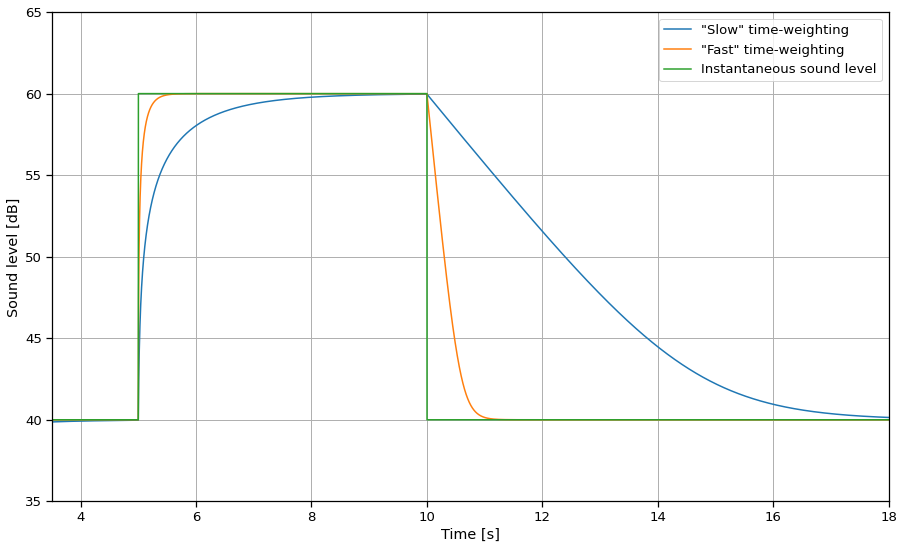

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15,9)
sns.set_context('notebook', font_scale=1.2)

plt.plot(np.arange(len(x))/FS, 20*np.log10(x_S), label='"Slow" time-weighting')
plt.plot(np.arange(len(x))/FS, 20*np.log10(x_F), label='"Fast" time-weighting')
plt.plot(np.arange(len(x))/FS, 20*np.log10(x), label='Instantaneous sound level')

plt.xlabel('Time [s]')
plt.ylabel('Sound level [dB]')
plt.xlim([3.5, 18])
plt.ylim([35, 65])
plt.legend()
plt.grid('on', which='both')

In [19]:
def rms(x):
    """ RMS level calculatiaon for the input signal 'x'. """
    return np.sqrt(np.mean(x**2))

def rms_t(x, t=1.0, fs=FS):
    """ RMS level calculation for the input signal 'x',
    in fragments of length 't'. """
    x = np.array(x, dtype='float64')
    N = int(np.floor(t*fs))
    start = np.arange(0, len(x), N) 
    end = np.append(start[1:], x.shape[0])
    y= np.empty(len(start))
    for i in range(len(start)):
        y[i] = rms(x[start[i]:end[i]])
    return y

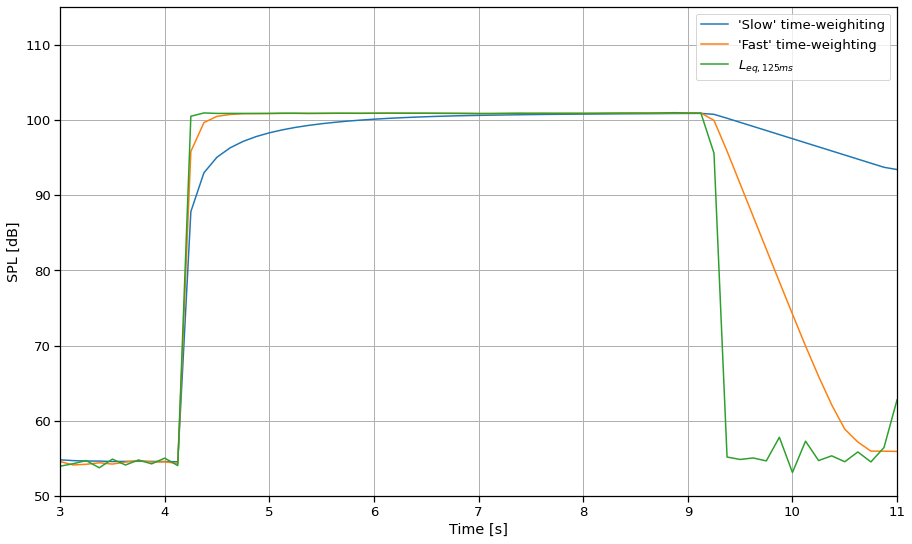

In [39]:
from scipy.signal import sosfilt

from sys import path
import os

path_parent = os.path.dirname(os.getcwd())
path.append(path_parent + '\\src') 

# importing from our utils module
from utils import wavread

# Loading and processing audio
# - - - - - - - - - - - - - - -

# load audio
fs, tone = wavread('../aud/tone_1k.wav')
# eliminating microphone's offset
tone = tone/np.mean(tone)-1

# load calibration file
_, cal = wavread('../aud/cal.wav')
# eliminating microphone's offset
cal = cal/np.mean(cal)-1

# applying time-weighting filters
tone_S = np.sqrt(sosfilt(sos_S, tone**2))
tone_F = np.sqrt(sosfilt(sos_F, tone**2))

# getting RMS levels at 0.125 s time intervals
F = 0.125
rms_x = rms_t(tone, t=F)
rms_S = rms_t(tone_S, t=F)
rms_F = rms_t(tone_F, t=F)

# Plotting
# - - - - - - - - - - - - - - -

# time vector in seconds
x_t = np.arange(0, len(rms_x)*F, F)

# calculating sound pressure levels and plotting
plt.plot(x_t, 94 + 20*np.log10(rms_S/rms(cal)), label="'Slow' time-weighiting")
plt.plot(x_t, 94 + 20*np.log10(rms_F/rms(cal)), label="'Fast' time-weighting")
plt.plot(x_t, 94 + 20*np.log10(rms_x/rms(cal)), label='$L_{eq,125ms}$')

plt.xlabel('Time [s]')
plt.ylabel('SPL [dB]')
plt.xlim([3, 11])
plt.ylim([50, 115])
plt.legend()
plt.grid('on', which='both')